In [2]:
'''PACKAGE IMPORTS'''
#For data analysis
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from matplotlib.gridspec import GridSpec
import numpy as np
import seaborn as sns
import scipy
import xarray as xr

In [3]:
'''Functions'''

def positive_cumsum(x):
    y = np.zeros(len(x))

    for i in range(1, len(x)-1):
        if(y[i-1] + x[i-1] < 0):
            y[i] = 0
        else:
            y[i] = y[i-1] + x[i-1]

    return y

In [4]:
'''Import Data'''
import_path = "./Cleaned Data/"
import_path_raw = "./Raw Data/"

In [5]:
### Import Snow Data
s2data = xr.open_dataset(import_path + '01_cleanedsnowdataS2.nc')
s2data_df = s2data.to_dataframe().reset_index(drop = False)
s2data_df = s2data_df.replace('NaN', np.nan)
s2data_df = s2data_df.replace('nan', np.nan)
s2data_df.time = pd.to_datetime(s2data_df.time)
s2data_df['watershed'] = 'S2'

s6data = xr.open_dataset(import_path + '01_cleanedsnowdataS6.nc')
s6data_df = s6data.to_dataframe().reset_index(drop = False)
s6data_df = s6data_df.replace('NaN', np.nan)
s6data_df = s6data_df.replace('nan', np.nan)
s6data_df.time = pd.to_datetime(s6data_df.time)
s6data_df['watershed'] = 'S6'

allSnow_df = pd.concat([s6data_df, s2data_df]).reset_index()

#Precipitation data - update from MN DNR site occasionally, eventually replace with MEF data
precip = pd.read_csv(import_path_raw + 'GrandRapids_Precip_MNDNR.csv', 
                     na_values = ['T', 'M'], 
                     parse_dates = ['Date'], 
                     names = ['Date', 'Tmax_F', 'Tmin_F', 'P_in', 'Snow_in', 'SnowDepth_in'], 
                     header = 0, 
                     dtype = {'P_in':float, 'Snow_in':float, 'SnowDepth_in':float})
precip = precip[precip.Date > '2022-10-01'].reset_index(drop = True)

### Import LAI Data
s2LAI = pd.read_csv(import_path + "S2_winterLAI_calibrated.csv")
s6LAI = pd.read_csv(import_path + "S6_winterLAI_calibrated.csv")
lai_df = pd.concat([s2LAI, s6LAI]).reset_index()

### Import Weekly Met Data
weeklyMet = pd.read_csv(import_path + "/ATM/WeeklyATMSummary.csv")

# Import SWE data
SWE = pd.read_csv(import_path + "2023SWE_data.csv", 
                parse_dates = ['DATE'])

In [6]:
SWE

,SITE,DATE,SWE_cm
0,S220,2023-01-13,3.556
1,S215,2023-01-13,7.620
2,S205,2023-01-13,5.080
3,S204,2023-01-13,0.254
4,S203,2023-01-13,8.128
...,...,...,...
614,S621,2023-04-27,NaN
615,S611,2023-04-27,NaN
616,S612,2023-04-27,4.826
617,S623,2023-04-27,11.430


In [7]:
allSnow_df

,index,time,northing,easting,depths,zones,stakes,aspect,slope,watershed
0,0,2022-12-02,464644.0,5262240.0,NaN,NaN,NaN,NaN,NaN,S6
1,1,2022-12-02,464644.0,5262449.0,5.5,Upland,S655,259.776300,6.629145,S6
2,2,2022-12-02,464644.0,5262658.0,8.0,Upland,S654,350.366600,1.924451,S6
3,3,2022-12-02,464644.0,5262867.0,NaN,NaN,NaN,NaN,NaN,S6
4,4,2022-12-02,464644.0,5263076.0,NaN,NaN,NaN,NaN,NaN,S6
...,...,...,...,...,...,...,...,...,...,...
1243,667,2023-05-05,464448.0,5262344.0,NaN,NaN,NaN,NaN,NaN,S2
1244,668,2023-05-05,464448.0,5262396.0,NaN,NaN,NaN,NaN,NaN,S2
1245,669,2023-05-05,464448.0,5262448.0,0.0,Upland,S254,225.000000,0.962290,S2
1246,670,2023-05-05,464448.0,5262500.0,0.0,Upland,S255,0.008743,1.431970,S2


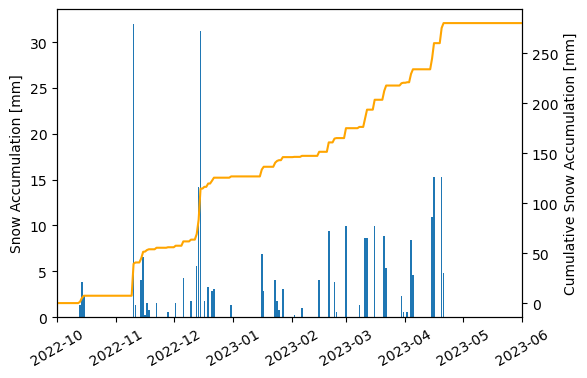

In [8]:
'''Open Canopy Snow_mm from GR'''
precip['Snow_mm'] = 25.4*(np.where(precip.Snow_in > 0.0, precip.P_in, 0)) #Convert in to mm

fig, ax = plt.subplots(1, 1, figsize = (6,4))
#Snow Inputs
ax.bar(precip.Date, precip.Snow_mm)
#Season Accumulation
ax2 = plt.twinx(ax)
ax2.plot(precip.Date, np.cumsum(precip.Snow_mm), color = 'orange')
plt.xlim('2022-10-01','2023-06-01')
plt.xlabel('Date')
ax.set_ylabel('Snow Accumulation [mm]')
ax2.set_ylabel('Cumulative Snow Accumulation [mm]')
ax.tick_params(axis='x', rotation=30)

In [53]:
'''Calculate Under Canopy Accumulation Rates'''
stakes = ['S236', 'S213', 'S632', 'S200', 'S623', 'S211', 'S633', 'S235', 'S644', 'S646', 'S202', 'S201', 'S204', 'S631', 'S645', 'S212', 'S221', 'S635', 'S621', 'S232', 'S222', 'S223', 'S624', 'S625', 'S655', 'S205', 'S246', 'S643', 'S225', 'S203', 'S622', 'S255', 'S654', 'S636', 'S224', 'S603', 'S612', 'S254', 'S642', 'S233', 'S215', 'S613', 'S245', 'S614', 'S234', 'S634', 'S220', 'S243', 'S611', 'S226', 'S244']

modelledSnow = pd.DataFrame()

#Calculate Snow in under the canopy
for stake in stakes:
    #lai at the site
    lai = float(lai_df['OLS Prediction Ring 5'].loc[lai_df.Stake_ID == stake].values)

    #select relevant data
    temp = allSnow_df[allSnow_df.stakes == stake].reset_index(drop = True)

    #merge with snow data
    temp2 = pd.merge(temp, precip[['Date', 'Tmax_F', 'Tmin_F', 'Snow_mm']], right_on = 'Date', left_on = 'time', how = 'right')

    #Temperature conversions
    temp2['Tavg_F'] = (temp2.Tmax_F + temp2.Tmin_F)/2
    temp2['Tavg_C'] = (temp2.Tavg_F - 32)/1.8000

    #Estimate Accumulation -- done in mm
    temp2['LAI'] = lai
    temp2['CanopyDensity'] = 0.29*(1.9 + np.log(temp2.LAI))
    temp2['Snow_mm_underCanopy'] = temp2.Snow_mm * [1 - ((0.144*np.log(lai))+0.223)]
    temp2['Interception_mm'] = temp2.Snow_mm - temp2.Snow_mm_underCanopy

    #Estimate melt -- done in cm 
    temp2['DDF'] = 0.292-0.164*temp2.CanopyDensity
    temp2['Melt_cm_potential'] = np.where(((temp2.Tavg_C > 0) & (temp2.Snow_mm == 0)), temp2.DDF*(temp2.Tavg_C - 0), 0)

    temp2['Snow_cm_underCanopy'] = temp2['Snow_mm_underCanopy']/10
    temp2['deltaSWE'] = temp2.Snow_cm_underCanopy - temp2.Melt_cm_potential
    temp2['SWE_cm'] = positive_cumsum(temp2.deltaSWE)
    temp2['Melt_cm_modelled'] = np.where(np.diff(temp2.SWE_cm, append = 0) < 0, -np.diff(temp2.SWE_cm, append = 0), np.nan)

    #reset stake label and site characteristics
    temp2['stakes'] = stake
    temp2['northing'] = temp.northing[0]
    temp2['easting'] = temp.easting[0]
    temp2['zones'] = temp.zones[0]
    temp2['aspect'] = temp.aspect[0]
    temp2['slope'] = temp.slope[0]
    temp2['watershed'] = temp.watershed[0]

    #concat
    modelledSnow = pd.concat([modelledSnow, temp2])

In [54]:
modelledSnow

,index,time,northing,easting,depths,zones,stakes,aspect,slope,watershed,...,LAI,CanopyDensity,Snow_mm_underCanopy,Interception_mm,DDF,Melt_cm_potential,Snow_cm_underCanopy,deltaSWE,SWE_cm,Melt_cm_modelled
0,NaN,NaT,464596.4,5262552.0,NaN,Upland,S236,4.635716,1.32895,S2,...,0.206218,0.093141,0.0,0.0,0.276725,4.150873,0.0,-4.150873,0.0,NaN
1,NaN,NaT,464596.4,5262552.0,NaN,Upland,S236,4.635716,1.32895,S2,...,0.206218,0.093141,0.0,0.0,0.276725,4.688949,0.0,-4.688949,0.0,NaN
2,NaN,NaT,464596.4,5262552.0,NaN,Upland,S236,4.635716,1.32895,S2,...,0.206218,0.093141,0.0,0.0,0.276725,4.765817,0.0,-4.765817,0.0,NaN
3,NaN,NaT,464596.4,5262552.0,NaN,Upland,S236,4.635716,1.32895,S2,...,0.206218,0.093141,0.0,0.0,0.276725,4.535213,0.0,-4.535213,0.0,NaN
4,NaN,NaT,464596.4,5262552.0,NaN,Upland,S236,4.635716,1.32895,S2,...,0.206218,0.093141,0.0,0.0,0.276725,1.306756,0.0,-1.306756,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,NaN,NaT,464522.2,5262448.0,NaN,Upland,S244,355.678900,8.02736,S2,...,0.296030,0.197984,0.0,0.0,0.259531,6.632449,0.0,-6.632449,0.0,NaN
299,NaN,NaT,464522.2,5262448.0,NaN,Upland,S244,355.678900,8.02736,S2,...,0.296030,0.197984,0.0,0.0,0.259531,5.839438,0.0,-5.839438,0.0,NaN
300,NaN,NaT,464522.2,5262448.0,NaN,Upland,S244,355.678900,8.02736,S2,...,0.296030,0.197984,0.0,0.0,0.259531,4.830153,0.0,-4.830153,0.0,NaN
301,NaN,NaT,464522.2,5262448.0,NaN,Upland,S244,355.678900,8.02736,S2,...,0.296030,0.197984,0.0,0.0,0.259531,4.613877,0.0,-4.613877,0.0,NaN


In [55]:
'''Estimate Melt from Measured SWE'''
SWE['Melt_cm'] = SWE.groupby('SITE')['SWE_cm'].diff().fillna(0)
SWE['Melt_cm'] = np.where(SWE.Melt_cm < 0, -SWE.Melt_cm, 0)
SWE

,SITE,DATE,SWE_cm,Melt_cm
0,S220,2023-01-13,3.556,0.0
1,S215,2023-01-13,7.620,0.0
2,S205,2023-01-13,5.080,0.0
3,S204,2023-01-13,0.254,0.0
4,S203,2023-01-13,8.128,0.0
...,...,...,...,...
614,S621,2023-04-27,NaN,0.0
615,S611,2023-04-27,NaN,0.0
616,S612,2023-04-27,4.826,0.0
617,S623,2023-04-27,11.430,0.0


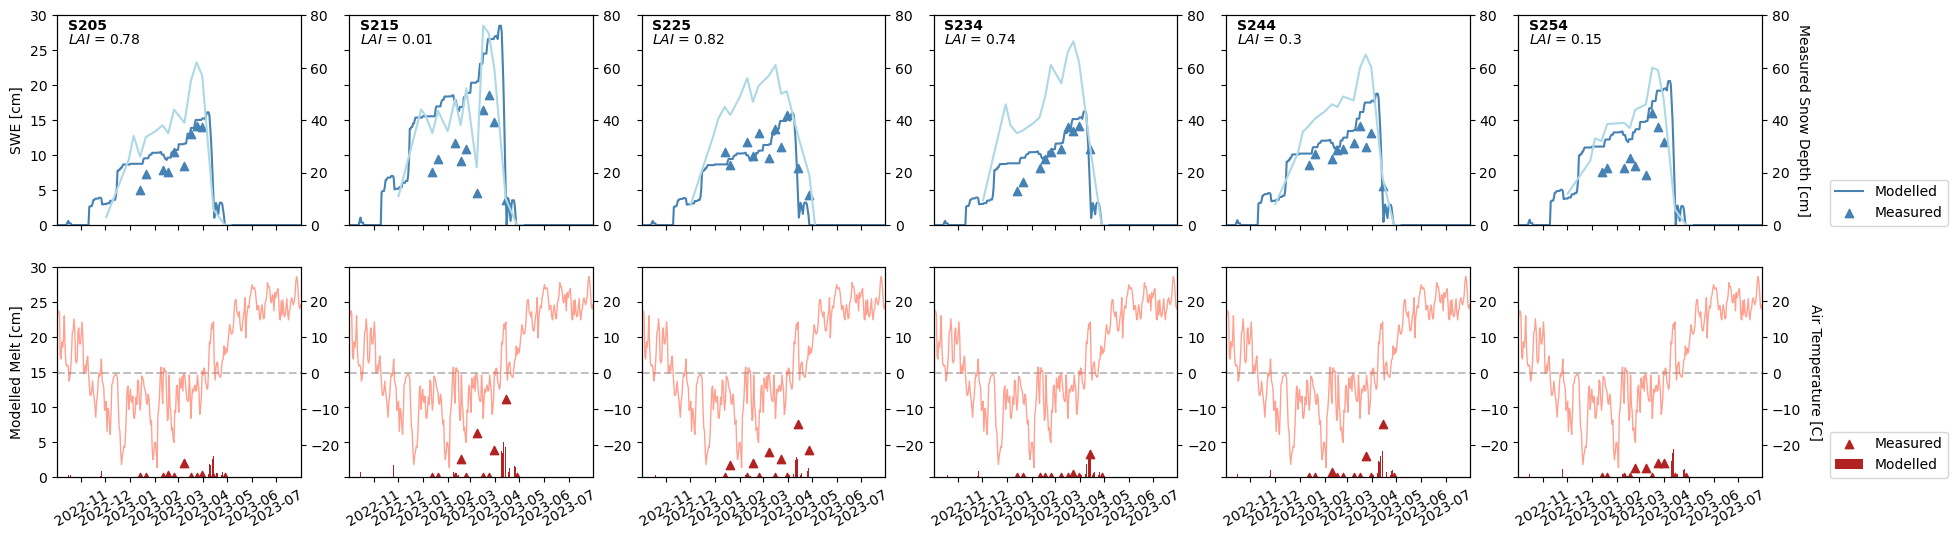

In [56]:
fig, axs = plt.subplots(2, 6, figsize = (22,6), 
                        sharex = True, 
                        sharey = True)

stakes = ['S205', 'S215', 'S225', 'S234', 'S244', 'S254']
for i in range(0, len(stakes)):
    stake = stakes[i]

    datasubset = modelledSnow[modelledSnow.stakes == stake].reset_index(drop = True)
    SWEsubset = SWE[SWE.SITE == stake]
    
    #Top row is SWE[ax1], snow depth[ax2], and interception[ax1]
    axs[0, i].plot(datasubset.Date, datasubset.SWE_cm, label = 'Modelled', color = 'steelblue')
    axs[0, i].scatter(SWEsubset.DATE, SWEsubset.SWE_cm, label = 'Measured', color = 'steelblue', marker = '^')
    axs[0, i].set_ylim(0, 30)
   
    axs_twin = plt.twinx(axs[0, i])
    sns.lineplot(data = datasubset, x = 'Date', y = 'depths', color = 'lightblue', ax = axs_twin)
    axs_twin.set_ylim(0, 80)

    #Bottom row is air temp[ax2] and melt[ax1]
    axs[1, i].bar(datasubset.Date, datasubset.Melt_cm_modelled, color = 'firebrick', label = 'Modelled')
    axs[1, i].scatter(SWEsubset.DATE, SWEsubset.Melt_cm, color = 'firebrick', marker = '^', label = 'Measured')

    axs1_twin = plt.twinx(axs[1, i])
    axs1_twin.hlines(0, min(modelledSnow.Date), max(modelledSnow.Date), color = 'silver', linestyle = '--')
    axs1_twin.plot(datasubset.Date, datasubset.Tavg_C, color = 'tomato', alpha = 0.6, linewidth = 1)

    #Plot settings
    plt.xlim(min(modelledSnow.Date), max(modelledSnow.Date))
    axs[1, i].tick_params(axis='x', rotation=30)

    if(i == 0):
        axs[0, i].set_ylabel('SWE [cm]')
        axs[1, i].set_ylabel('Modelled Melt [cm]')
        axs_twin.set_ylabel(' ')

    elif(i == 5):
        axs_twin.set_ylabel('Measured Snow Depth [cm]', rotation = 270, labelpad = 15)
        axs1_twin.set_ylabel('Air Temperature [C]', rotation = 270, labelpad = 15)
        axs[0, i].legend(bbox_to_anchor=(1.25, 0.25))
        axs[1, i].legend(bbox_to_anchor=(1.25, 0.25))

    else:
        axs_twin.set_ylabel(' ')

    #Plot text
    axs[0, i].text('2022-10-15', 28, stake, fontweight = 'bold')
    axs[0, i].text('2022-10-15', 26, '$LAI$ = ' + str(np.round(datasubset.LAI[0], 2)))


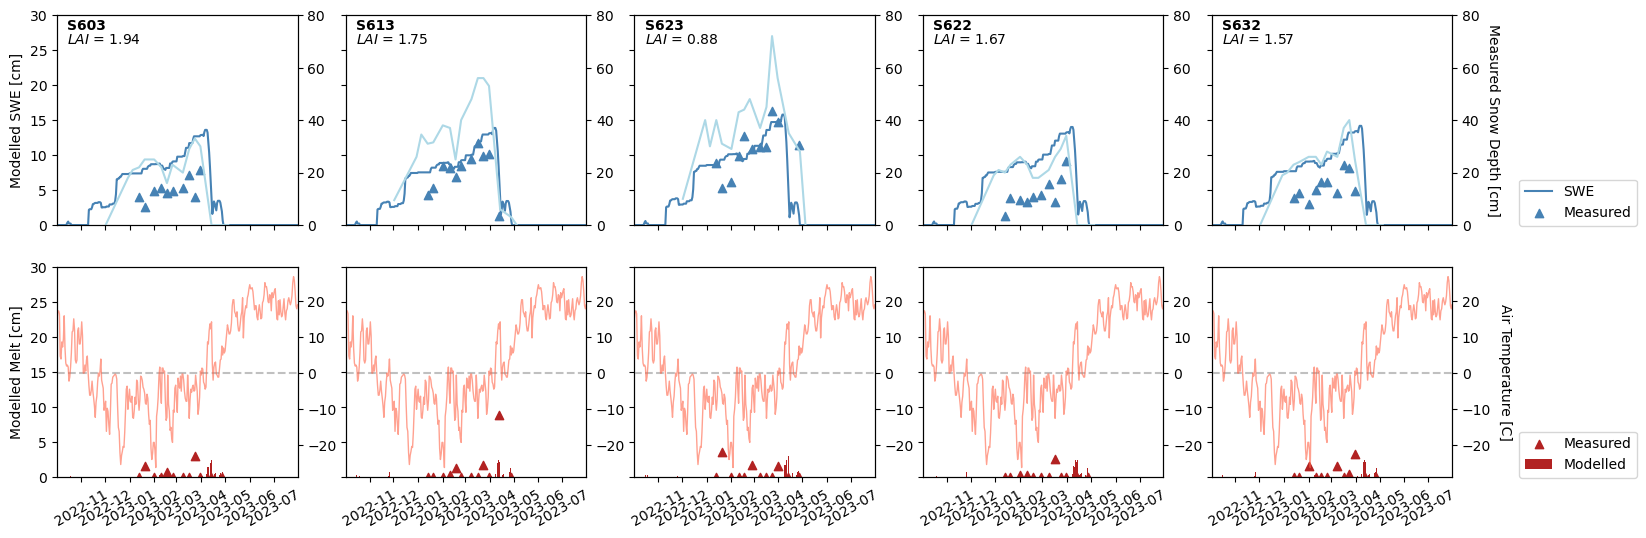

In [57]:
fig, axs = plt.subplots(2, 5, figsize = (18,6), 
                        sharex = True, 
                        sharey = True)

stakes = ['S603', 'S613', 'S623', 'S622', 'S632']
for i in range(0, len(stakes)):
    stake = stakes[i]

    datasubset = modelledSnow[modelledSnow.stakes == stake].reset_index(drop = True)
    SWEsubset = SWE[SWE.SITE == stake]
    
    #Top row is SWE[ax1], snow depth[ax2], and interception[ax1]
    axs[0, i].plot(datasubset.Date, datasubset.SWE_cm, label = 'SWE', color = 'steelblue')
    axs[0, i].scatter(SWEsubset.DATE, SWEsubset.SWE_cm, label = 'Measured', color = 'steelblue', marker = '^')
    axs[0, i].set_ylim(0, 30)
    
    axs_twin = plt.twinx(axs[0, i])
    sns.lineplot(data = datasubset, x = 'Date', y = 'depths', color = 'lightblue', ax = axs_twin)
    axs_twin.set_ylim(0, 80)

    #Bottom row is air temp[ax2] and melt[ax1]
    axs[1, i].bar(datasubset.Date, datasubset.Melt_cm_modelled, color = 'firebrick', label = 'Modelled')
    axs[1, i].scatter(SWEsubset.DATE, SWEsubset.Melt_cm, color = 'firebrick', marker = '^', label = 'Measured')

    axs1_twin = plt.twinx(axs[1, i])
    axs1_twin.hlines(0, min(modelledSnow.Date), max(modelledSnow.Date), color = 'silver', linestyle = '--')
    axs1_twin.plot(datasubset.Date, datasubset.Tavg_C, color = 'tomato', alpha = 0.6, linewidth = 1)

    #Plot settings
    plt.xlim(min(modelledSnow.Date), max(modelledSnow.Date))
    axs[1, i].tick_params(axis='x', rotation=30)

    if(i == 0):
        axs[0, i].set_ylabel('Modelled SWE [cm]')
        axs[1, i].set_ylabel('Modelled Melt [cm]')
        axs_twin.set_ylabel(' ')
    elif(i == 4):
        axs_twin.set_ylabel('Measured Snow Depth [cm]', rotation = 270, labelpad = 15)
        axs1_twin.set_ylabel('Air Temperature [C]', rotation = 270, labelpad = 15)
        axs[0, i].legend(bbox_to_anchor=(1.25, 0.25))
        axs[1, i].legend(bbox_to_anchor=(1.25, 0.25))
    else:
        axs_twin.set_ylabel(' ')

    #Plot text
    axs[0, i].text('2022-10-15', 28, stake, fontweight = 'bold')
    axs[0, i].text('2022-10-15', 26, '$LAI$ = ' + str(np.round(datasubset.LAI[0], 2)))


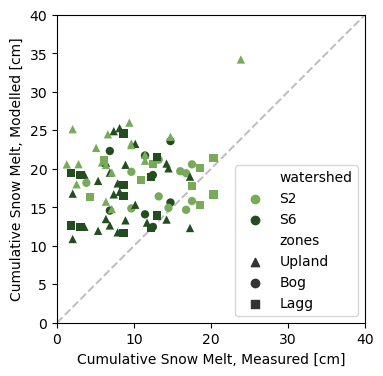

In [70]:
'''Cumulative estimated Melt'''

#Merge in measrued SWE data
modelledSnow_SWE = modelledSnow.merge(SWE, right_on = ['DATE', 'SITE'], left_on = ['Date', 'stakes'], how = 'outer')
modelledSnow_SWE = modelledSnow_SWE.rename(columns = {'SWE_cm_x' : 'SWE_cm_modelled', 
                         'SWE_cm_y' : 'SWE_cm_measured', 
                         'Melt_cm' : 'Melt_cm_measured'})

#Track cumulative melt
modelledSnow_SWE['Melt_cm_measured_cumsum'] = modelledSnow_SWE.groupby(['stakes'])['Melt_cm_measured'].cumsum()
modelledSnow_SWE['Melt_cm_modelled_cumsum'] = modelledSnow_SWE.groupby(['stakes'])['Melt_cm_modelled'].cumsum()

#Plot
fig, ax = plt.subplots(1, 1, figsize = (6,4))

ax.axline(xy1 = [0, 0], xy2 = [40, 40], linestyle = '--', color = 'silver', zorder = -5)
sns.scatterplot(data = modelledSnow_SWE, x = 'Melt_cm_measured_cumsum', y = 'Melt_cm_modelled_cumsum',
                hue = 'watershed', style = 'zones', 
                palette = {'S2': '#77ab59', 'S6': '#234d20'}, 
                linewidth = 0,
                markers = ['^', 'o', 's'])
ax.set_xlabel('Cumulative Snow Melt, Measured [cm]')
ax.set_ylabel('Cumulative Snow Melt, Modelled [cm]')
ax.set_xlim(0, 40)
ax.set_ylim(0, 40)
ax.set_aspect('equal')
ax.legend()



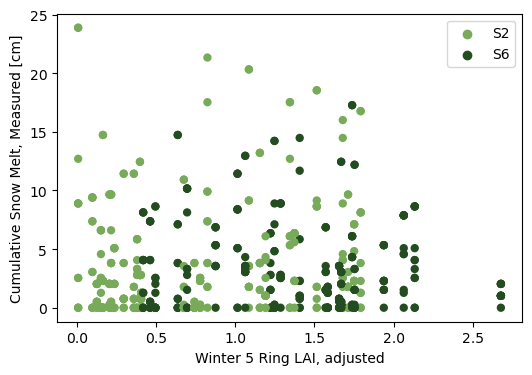

In [78]:
'''LAI and measured Snow melt'''
#Plot
fig, ax = plt.subplots(1, 1, figsize = (6,4))

sns.scatterplot(data = modelledSnow_SWE, x = 'LAI', y = 'Melt_cm_measured_cumsum',
                hue = 'watershed',
                palette = {'S2': '#77ab59', 'S6': '#234d20'}, 
                linewidth = 0)
ax.set_xlabel('Winter 5 Ring LAI, adjusted')
ax.set_ylabel('Cumulative Snow Melt, Measured [cm]')
ax.legend()
